# Gender Recognition of Farsi names using methods of Statistical Learning and Deep Learning
> Writen by ***Alireza Khalilian*** - *Aug 2024*

In this notebook, we explore the intriguing problem of gender recognition (or gender classification) for Farsi (Persian) names. We employ various classification methods, including KNN, SVM, Random Forests, ANN, CNN, and RNN, to determine the most effective approach for this task. Each model's performance will be compared against a baseline dummy classifier, and hypothesis testing will be conducted on the accuracy of each model using an alpha value of 0.05.

# Table of Contentes
- [__Dataset__](#Dataset)
- [__Preprocessing__](#Preprocessing)
- [__Visualization__](#Visualization)
- [__Classification__](#Classification)
    - [Basic Models](#Basic-Models)
      - [KNN](#K-Nearest-Neighbours)
      - [SVM](#Kerneled-SVM)
      - [Random Forest](#Random-Forests)
      - [Sensitivity Analysis](#Sensetivity-Analysis)
    - [Artificial Neural Networks]()
        - [Dense Neural Networks]()
        - [Recursive Neural Networks]()
- [__Comparing Results__](#Comparing-the-Results)
- [__Conclusion__](#Conclusion)

In [1]:
import char_map
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import seaborn as sns
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
import scipy
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

2024-08-31 13:55:30.926781: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-31 13:55:31.763293: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset
The dataset was initially provided by the PayPing company, though it is relatively small, containing only about 6,000 samples. Another notable dataset is available in the Persian-gender-detection package within [this repository](https://github.com/zeoses/persian-gender-detection/tree/main), which includes approximately 19,000 entries, making it more suitable for real-world applications. Additionally, a list of other available datasets is as follows:
- [Persian-gender-detection](https://github.com/zeoses/persian-gender-detection/tree/main)
- [Persian(Farsi) Names Dataset](https://www.kaggle.com/datasets/hamedetezadi/persianfarsi-names-dataset)
- [nabidam - Persian Names](https://github.com/nabidam/persian-names)
- [Dataset for names of people in Persian language](https://www.kaggle.com/datasets/rezaali/dataset-for-names-of-people-in-persian-language).

Additionally, since Iran shares a common history with several other countries, such as Tajikistan, Azerbaijan, Afghanistan, and Iraq, names from these regions can be combined and used together.

In [2]:
df = pd.read_excel('FirstNames.xlsx')

# Preprocessing
In order to make the data suitable for any machine learning task, the first step that needs to be done is the preprocessing of the data. This step is crucial because it directly impacts the performance, accuracy, and reliability of the models. Various steps can be taken to prepare the data for the model including:

1. Handling Missing Data
2. Normalization/Standardization
3. Feature Engineering
4. Handling Categorical Data
5. Removing Duplicates
6. Handling Text Data
7. Splitting the Data

## Cleaning Up the labels
The provided dataset contains four columns: the first column lists names in Farsi, the second and third columns specify gender, and the fourth column indicates the commonness of the name in the Farsi language. However, the labeling of names is not suitable for our classification problem. Each name is tagged either in the "Pesar" column, which indicates a male name, or in the "Dokhtar" column, which indicates a female name.

We can approach this problem in two different ways:

- __One Hot Encoding of the lables__:  In this approach, each label is mapped to a vector where each element is either 0 or 1. We will create a vector $[1,0]$ for males and another vector $[0,1]$ for females. This approach is useful when the machine learning model supports __multiclass classification__ (e.g., Softmax Classification).
 
- __Binary labels__: Binary labels are simpler and can be used with standard models such as traditional SVM classifiers or SGD classifiers. Note that modified versions of these models support multiclass classification.

Here we will regenerate both type of labels so that we can use either of them when neccessary.

In [3]:
## Function for generating the binary labels
def binary_labels(inp_row):

    if inp_row['Pesar'] == 1.0  and inp_row['Dokhtar'] == 1.0:
        return 2
        
    elif inp_row['Pesar'] == 1.0:
        return 0

    elif inp_row['Dokhtar'] == 1.0:
        return 1

    else: return -1

## Function for generating the one-hot-encoded labels
def one_hot_encoded_labels(inp_row):
    
    if inp_row['Dokhtar'] == 1.0 and inp_row['Pesar'] == 1.0:
        return np.array([1,1])

    elif inp_row['Pesar'] == 1.0:
        return np.array([1,0])

    elif inp_row['Dokhtar'] == 1.0:
        return np.array([0,1])


    else: return np.array([0,0])

In [4]:
## Create two additional columns, One for one-hot-encoeded labels and one for binary labels.
df['gender_bin'] = df.apply( binary_labels , axis = 1)
df['gender_one_hot'] = df.apply( one_hot_encoded_labels , axis = 1)

## Remove the unneccessary columns by droping them.
df = df.drop(['Pesar' , 'Dokhtar', 'Rate'] , axis = 1)
df.columns = ['name', 'gender_bin', 'gender_one_hot']

## Checking for the unlabeled or mislabeled data
There are over 6000 data points in this dataset. All of these data needs to be examined to find any mislabeled (names with both _Pesar_ label and _Dokhtar_ labels) or unlabeled names (names with neither _Pesar_ label or _Dokhtar_ label). Fortunatly, when the new labels were created, these cases were considered. A binary label of $2$ means a mislabeled entry and a binary label of $-1$ means an unlabeled entry. These entries, if found, need to be removed.

In [5]:
miss_count = df['gender_bin'].where(df['gender_bin'] == 2).count()
unlab_count = df['gender_bin'].where(df['gender_bin'] == -1).count()
print(f'Mislabels: {miss_count} \t Unlabeled: {unlab_count}')

Mislabels: 291 	 Unlabeled: 0


In [6]:
df = df.drop(index = df[df['gender_bin'] == 2].index, axis = 0)
df = df.drop(index = df[df['gender_bin'] == -1].index, axis = 0)

## Cleaning Up NaNs
In any dataset, unassigned entries can be found. These are anomalies which can create problems for the models later on so they should be removed too.

In [7]:
df = df.drop(index = df[df['name'] == np.nan].index, axis = 0)

## Cleaning up the _Name_ column
The Farsi language uses the Arabic script, but it only utilizes a portion of the symbols found in the Arabic writing system. For example, symbols like __Tashdid__, while occasionally used, are not common in Farsi. Additionally, many other symbols, such as diacritics, are unnecessary for our purposes. Therefore, we should either remove or convert these unused symbols to the standard 32 Farsi letters; Including a space character for names like "علی رضا," this gives us 33 unique tokens to work with.

Fortunatly, PayPing provided a substitute table (can be found in `char_map.py`) which we'll use to clean up the names.

In [8]:
# For our purposes, we will convert all the characters in name to "FARSI" characters.
df['name'] = df['name'].apply( lambda x: ''.join([char_map.char_mappings[let] if let not in char_map.valid_chars else let for let in x]))

## Vectorizing the Names
Machine learning models require numerical data to function. Therefore, names must be converted into numerical vectors before being input into a model. In Natural Language Processing, several techniques are available for text vectorization. Since our classification task operates at the character level, we need to assign vectors to each character and then combine them into a single vector.

For this task, three methods can be used.

### Ordinal Vectorization
For ordinal vectorization, a number will be assigned to each letter of the alphabet. Afterwards, a vector of fixed size will be used to represent the names where each element of it will corespond to a letter in the alphabet.
$$ a = 1,\;b = 2,\;c = 3 $$
$$(abaac)_5 = [1 , 2, 1, 1, 3]$$
$$(abaac)_7 = [1 , 2, 1, 1, 3, 0, 0]$$  

### Binary Vectorization
In this case, each letter will be assigned a unique binary vector. These binary vectors will later be combined to create a fixed size vector representing the name.
$$ a = [1,0],\;b = [0,1],\;c = [1,1] $$
$$(abaac)_{10} = [1, 0, 0, 1, 1, 0, 1, 0, 1, 1]$$
$$(abaac)_{16} = [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]$$

### One Hot Encoding
Just like in the one hot encoded labels, a vector with the size of our alphabet will be used to represent each letter. For example, if we have $ Alphabet = \{ a , b, c\}$ as our alphabet, a vector of size $3$ is used where all the elements but one are zeros. The nonzero element in this case represent different characters of the alphabet. Finally, like in the binary vectorization, all character vectors are combined (with apropriate padding) to create a vector representation of names.
$$ a = [1,0,0] $$
$$ b = [0,1,0] $$
$$ c = [0,0,1] $$
$$(abaac)_{15} = [1,0,0,0,1,0,1,0,0,1,0,0,0,0,1]$$
$$(abaac)_{20} = [1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0]$$

For our case, we will incoporate one hot encodeing as it was successfully used in previous studies [[1]](./2106.10156v2.pdf).

In [9]:
## calculate the length of each name. We will use the maximum length name to determine our fixed size vector.
df['length'] = df['name'].apply( len )
df['length'].describe()

count    5883.000000
mean        5.491926
std         1.565979
min         2.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        12.000000
Name: length, dtype: float64

In [10]:
set_of_chars = char_map.valid_chars
unique_char_count = len(set_of_chars)
word_vector_size = unique_char_count * df['length'].max()

print('One Hot Encoded Vector Size:', word_vector_size)

One Hot Encoded Vector Size: 396


Hence, each name will be represented as a $ (1 \times 396) $ vector. However, we can limit the number of characters to like $8$ characters so the vector will be of size $( 1 \times 264 )$.

In [11]:
## Create a table lookup for the characters | assign each character a unique number
char_table_lookup = {key : val for val , key in enumerate(set_of_chars)}
print(char_table_lookup)

{'م': 0, 'ق': 1, 'ص': 2, ' ': 3, 'د': 4, 'گ': 5, 'خ': 6, 'ت': 7, 'ج': 8, 'ر': 9, 'پ': 10, 'ف': 11, 'ل': 12, 'ژ': 13, 'ط': 14, 'غ': 15, 'ه': 16, 'ک': 17, 'و': 18, 'ض': 19, 'س': 20, 'ش': 21, 'ع': 22, 'ب': 23, 'ی': 24, 'ا': 25, 'ظ': 26, 'چ': 27, 'ذ': 28, 'ن': 29, 'ح': 30, 'ث': 31, 'ز': 32}


In [12]:
def letter_encoder(type_ , num_of_letters = 12):

    total_number_of_features = num_of_letters * unique_char_count
    ohe_features = unique_char_count

    def numerical_encoder(name):

        if len(name) > num_of_letters:
            name = name[:num_of_letters]

        enc = [-1] * num_of_letters

        for i , ch in enumerate(name):
            enc[i] = char_table_lookup[ch]
                
        return np.array(enc)

    def one_hot_encoder(name):
        enc = []
        if len(name) > num_of_letters:
            name = name[:num_of_letters]

        for ch in name:
            letter_encoding = [0] * ohe_features
            letter_encoding[char_table_lookup[ch]] = 1
            enc.extend(letter_encoding)

        if len(name) < num_of_letters:
            enc.extend( [0] * (num_of_letters - len(name)) * ohe_features)

        return np.array(enc)

    if type_ == 'ohe':
        return one_hot_encoder

    elif type_ == 'numerical':
        return numerical_encoder

In [24]:
encoder = letter_encoder('ohe' , 10)
df['encode'] = df['name'].apply(encoder)
df.head()

,name,gender_bin,gender_one_hot,length,encode
0,ابده,0,"[1, 0]",4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ابیش,0,"[1, 0]",4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,اپروند,0,"[1, 0]",6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,اپرویژ,0,"[1, 0]",6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,اپیوه,0,"[1, 0]",5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Visualization
Visualizing data before solving a problem is essential because it helps us understand the data's structure, identify patterns, detect outliers, and generate hypotheses. It guides model selection, informs data preprocessing, and aids in communicating findings. By revealing critical insights early on, visualization ensures a more informed and effective approach to problem-solving.

## Male VS Female
Let's start by examining the distribution of each class in our dataset, the number of male and female names. A significant imbalance in class distribution can introduce bias into the model, affecting its performance. Therefore, it's important to assess whether we need to adjust the __class weights__ in the models to address any disparities.  
However as we can see in the _Gender Count_ figure bellow, the imbalance is negligible.

In [25]:
number_of_girls = df['gender_bin'][df['gender_bin'] == 1].count()
number_of_boys = df['gender_bin'][df['gender_bin'] == 0].count()

print(f'Number of Boys: {number_of_boys} \t Number of Girls: {number_of_girls}  \t Total Entry: {df.shape[0]}')

Number of Boys: 2841 	 Number of Girls: 3042  	 Total Entry: 5883


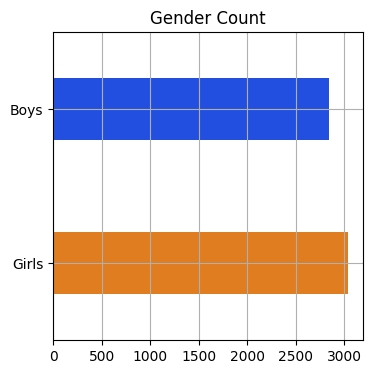

In [26]:
plt.figure(figsize=(4, 4))
ax = sns.barplot( {'Boys': [number_of_boys], 'Girls': [number_of_girls]}, orient='h', width=0.4 , palette = "bright")
ax.grid(True)
_ = ax.set_title('Gender Count')

## Name Lengths
Another interesting aspect to explore is plotting the length of each name. This is particularly useful if we plan to limit our vectorization to less than 12 characters.

### Result
As it is vivid in the graphs down bellow, the average name length is between $5$ and $6$ with the names between $4$ and $8$ being most common in both genders. So, if we plan to reduce the size of the name vectors, we can set it to around $8$ and not miss out on much.

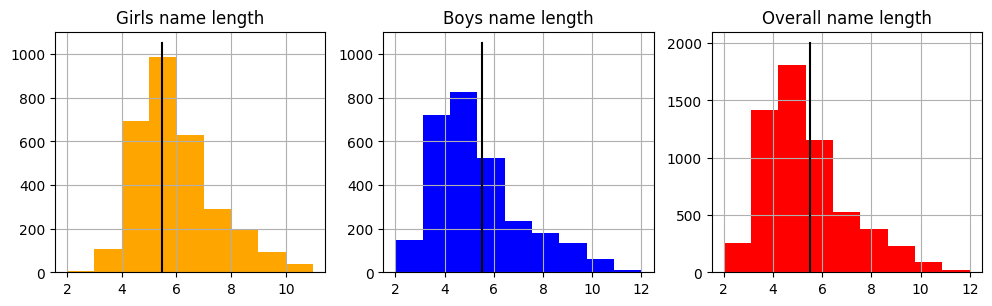

In [27]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(3)
fig.set_figwidth(10)
fig.tight_layout()

df['length'].where(df['gender_bin'] == 1).hist(bins =9, ax = axs[0], color = 'orange')
df['length'].where(df['gender_bin'] == 0).hist(bins = 9, ax = axs[1], color = 'blue')
df['length'].hist(bins = 9, ax = axs[2], color = 'red')

mean_girls = df['length'].where(df['gender_bin'] == 1).mean()
mean_boys =  df['length'].where(df['gender_bin'] == 0).mean()
mean_ = df['length'].mean()

axs[0].set_title('Girls name length')
axs[1].set_title('Boys name length')
axs[2].set_title('Overall name length')

axs[0].plot( [mean_girls , mean_girls] , [0,1050] , c = 'black')
axs[1].plot( [mean_boys , mean_boys] , [0,1050] , c = 'black')
axs[2].plot( [mean_ , mean_] , [0,2000] , c = 'black')

## Character Frequencies
Just like the distribution of lengths, character frequencies can also be charted to determine the most usefull characters in the whole dataset. This can also be used to reduce the number of features in One Hot Encoding by removing the less usefull characters.

In [28]:
char_freq_male = {key : 0 for key in set_of_chars}
char_freq_female = {key : 0 for key in set_of_chars}
char_freq = {key : 0 for key in set_of_chars}

for idx, row in df.iterrows():
    for ch in row['name']:
        if row['gender_bin'] == 1:
            char_freq_female[ch] += 1
        if row['gender_bin'] == 0:
            char_freq_male[ch] += 1

        char_freq[ch] += 1

ordered_frq_female = list(set_of_chars)
ordered_frq_female.sort( key = lambda x : char_freq_female[x])

ordered_frq_male = list(set_of_chars)
ordered_frq_male.sort( key = lambda x : char_freq_male[x])

ordered_frq = list(set_of_chars)
ordered_frq.sort( key = lambda x : char_freq[x])

Text(0.5, 1.0, 'Char Frequency Male')

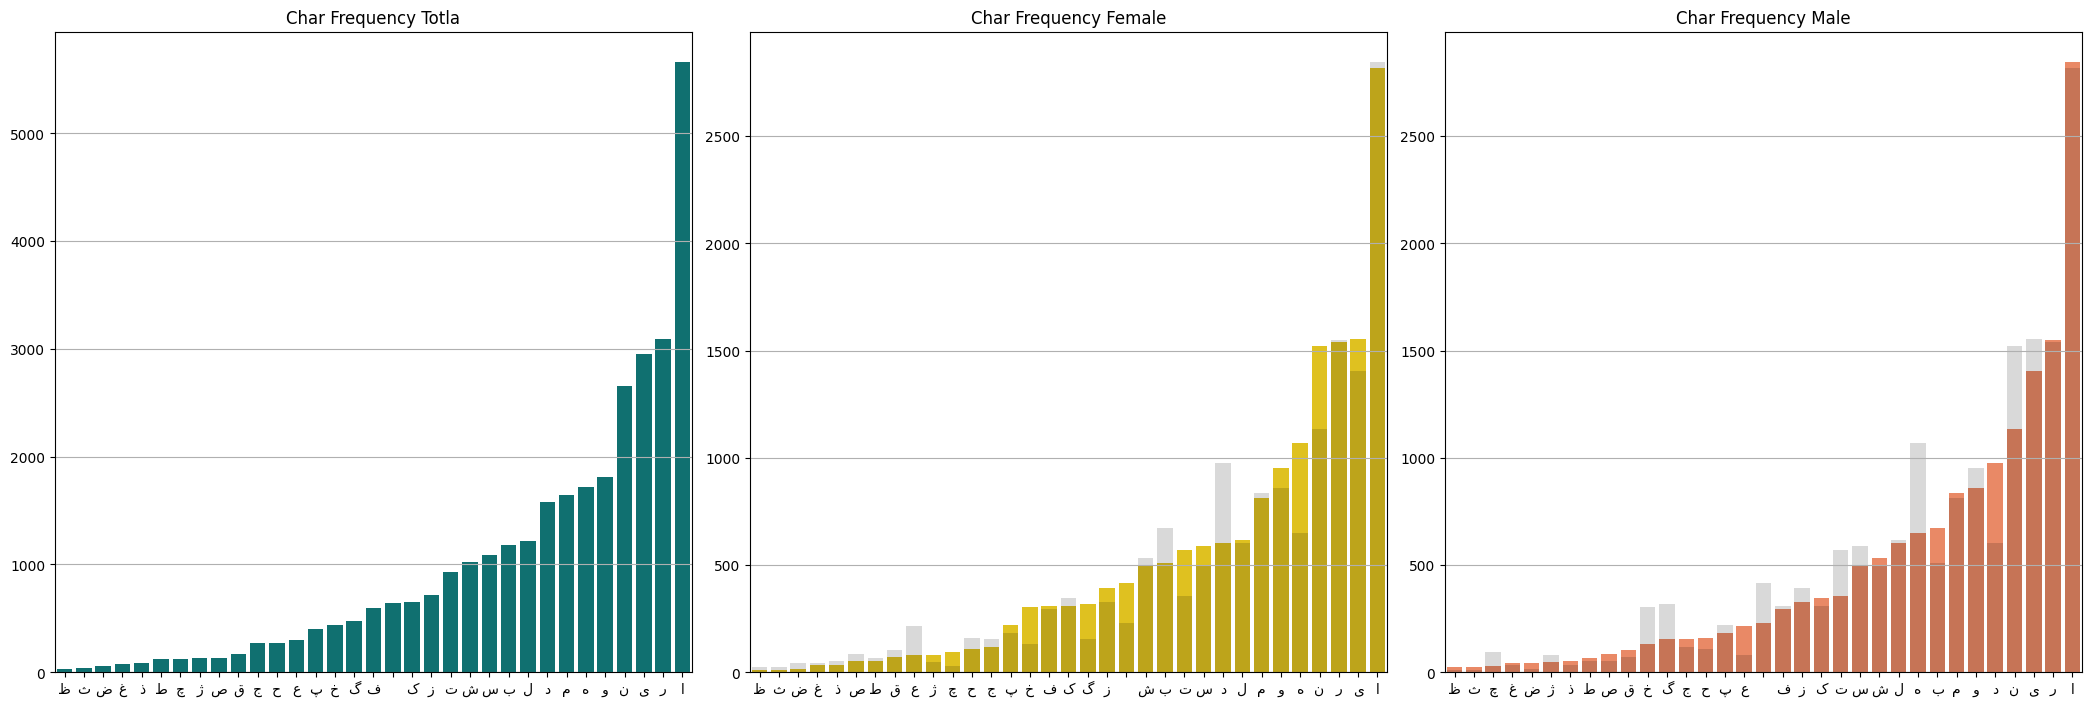

In [29]:
fig, axs = plt.subplots(1,3)
fig.set_figwidth(21)
fig.set_figheight(7)
fig.tight_layout()

axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)

sns.barplot(char_freq, order = ordered_frq, ax = axs[0] , color='teal')

sns.barplot(char_freq_female, order = ordered_frq_female, ax = axs[1], color='gold')
sns.barplot(char_freq_male, order = ordered_frq_female, ax = axs[1], color='black' , alpha = 0.15)

sns.barplot(char_freq_male, order = ordered_frq_male, ax = axs[2], color='coral')
sns.barplot(char_freq_female, order = ordered_frq_male, ax = axs[2], color='black' , alpha = 0.15)

axs[0].set_title('Char Frequency Totla')
axs[1].set_title('Char Frequency Female')
axs[2].set_title('Char Frequency Male')

We can See that the data (char frequencies) has an almost __exponantial__ trend which is expected. Also, in the plots regarding male and female frequencies, we also ploted the opposite sides bar in gray so we can compare them easily. For example it is vivid that the letter 'د' is used most commonly in male name and the letter 'ه' is more common in female names.

## Possibility for Feature Engineering
As we mentioned before, we can limit both the _number of characters_ to consider for each name and also we can limit the encoding of the characters to only those with consider repetition in our dataset. However these are methods of __Dimensionality Reduction__ to make our models lighter, less prone to overfitting and avoid some nasty side effects like the _Curse of Dimentionality_. 

One other method that we can use to go beyond the limits of our 33 characters is to create more features using __Polynomial Combinations__. In this method, new features will be added to our dataset which are polynomial combinations (specificaly $degree = n$ combinations) of our previous features. Using this, we can also consider the effect of character combinations (eg, 'مه' in names such as 'مهسا' and 'مهتاب' and etc.). However, this will increase the size of features with an alarming rate.
Consider our current $33$ characters and $10$ name length; In total, we have $ 330 $ features. The number of features after polynomial combinations of degree $2$ can be caluculated as:
$$ \dbinom{k + n}{k} - 1 = \dbinom{2 + 330}{2} - 1 = \frac{332!}{330! \times 2!} - 1 = 54,945$$
And with degree $3$:
$$ \dbinom{k + n}{k} - 1 = \dbinom{3 + 330}{3} - 1 = \frac{333!}{330! \times 3!} - 1 = 6,099,005$$

There are other methods of Dimension Reduction such as **_PCA_** to reduce the size of these massive vectors but, after previously implementing it in the _test phase_, we didn't see considerable improvement in accuracy, hence we will be using our $330$ featured vector.

# Classification
In this section, we will tackle different Machine Learning models to find the best one for our task.

In [98]:
X_ = np.stack(df['encode'].to_numpy() , axis = 0)

y_sl = df['gender_bin'].to_numpy()
y_dl = np.stack(df['gender_one_hot'].to_numpy() , axis = 0)
print(X_.shape)

(5883, 330)


In [31]:
X_train, X_test, y_train_sl, y_test_sl = train_test_split(X_ , y_sl , test_size = 0.25)

## Basic Models
In this section, we will perform classification on our data using basic models such as KNN, Kerneled-SVM and RandomForests. In some cases, where the complexity (for example non-linearity) of the data is low, these basic models will perform just as good as a complex model (ie. CNNs) without the processing overhead.

### The Dummy Classifier
Before we begin to train model, we use a dummy classifier in order to compare our results to it afterwards. This classifier randomly guesses one of the labels each time it is called.


In [32]:
dummy = DummyClassifier(strategy='uniform')
dummy.fit(X_train, y_train_sl)

DummyClassifier(strategy='uniform')

In [33]:
print(classification_report( y_test_sl , dummy.predict(X_test) ))
dummy_acc = accuracy_score(y_test_sl , dummy.predict(X_test))

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       723
           1       0.50      0.51      0.51       748

    accuracy                           0.49      1471
   macro avg       0.49      0.49      0.49      1471
weighted avg       0.49      0.49      0.49      1471



#### Some random tests

In [34]:
names_ = ['میترا' , 'رها' , 'حمید' , 'زیبا' , 'فریبا']
for name in names_:
    pred_ = dummy.predict([encoder(name)])
    if pred_:
        print(name, "=>" , 'دختر است')

    else:
        print(name, "=>" , 'پسر است')

میترا => پسر است
رها => پسر است
حمید => دختر است
زیبا => پسر است
فریبا => دختر است


### K-Nearest Neighbours
The first model that we encoporate is KNN. This model is lightweight and there is a meaningful interpetation behind it. KNN works great with medium sized datasets however, if we have large input features, for example if we decide to add polynomial relations between features, the models performance will be poor due to the curse of dimentionality.
#### Advantages
- No training phase (traditional).
- Non-parametric (KNN doesn’t assume any underlying distribution of the data).
- Handles non-linearity.
#### Disadvantages
- Memory Intensive.
- Must have small amount of features.
- Sensitive to noise.
- Poorly handles imbalanced classes.

In [35]:
knn_cls = KNeighborsClassifier(n_neighbors=16, n_jobs=5, weights = 'distance')

In [36]:
knn_cls.fit(X_train, y_train_sl)

KNeighborsClassifier(n_jobs=5, n_neighbors=16, weights='distance')

In [37]:
print(classification_report( y_test_sl , knn_cls.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.71      0.64      0.67       723
           1       0.68      0.75      0.71       748

    accuracy                           0.70      1471
   macro avg       0.70      0.69      0.69      1471
weighted avg       0.70      0.70      0.69      1471



#### Parameter Optimization
Afterwards, we perform grid-search on __number of neighbours__ to determine which parameter for the $K$ works best on our _Training Data_.

In [38]:
param_grid = [{'n_neighbors' : np.arange(5,20), 'weights' : ['distance' , 'uniform']}]
gs = GridSearchCV( knn_cls , param_grid , cv = 5 , scoring='accuracy' , return_train_score=True)

# gs.fit(X_train , y_train_sl)

In [39]:
# print('Best Parameter' , gs.best_params_ , 'Best Score', gs.best_score_)

Hence, we will create the classifier agan (already did) using $16$ for the number of neighbours.

#### Hypothesis Testing
Now that we have a model, we form our null hypothesis:
> There is no difference between K-NN model and the Dummy classifier.

To test this, we will calculate the P-Value by assuming that the dummy classifier use a __Bionomial Distribution__ to calculate labels with $ p = \frac{1}{2}$.  
Afterwards, using the bionomial distribution, we'll calculate the probablity of achiving the accuracy of K-NN (or more significant).

In [40]:
## Calculate the p-value
knn_acc = accuracy_score(y_test_sl , knn_cls.predict(X_test))
sample_size = y_test_sl.shape[0]

p_bionom_cdf = 1 - scipy.stats.binom.cdf( knn_acc * sample_size , sample_size , dummy_acc ) ## 0.5 because dummy's guesses are uniform
print('P-Value:' , p_bionom_cdf)

P-Value: 0.0


Just for the good measure, we will also perform a randomized test to determine an aproximate for the P-Value.

In [41]:
itterations = 10000
resulted_acc = np.zeros(itterations)

for i in range(itterations):
    cur_acc = accuracy_score(y_test_sl , dummy.predict(X_test))
    resulted_acc[i] = cur_acc

p_random = np.sum(resulted_acc > knn_acc) / itterations
print('P-Value (random-test):' , p_random)

P-Value (random-test): 0.0


The calculated P-Value from both tests are 0. Hence it beats our significance level $(0.05)$ and we conclude that the null hypothesis is wrong.

#### Some random tests
Here, we will give some random names to the model so we can visualize the models response in action. 

In [42]:
names_ = ['میترا' , 'رها' , 'حمید' , 'زیبا' , 'فریبا']
for name in names_:
    pred_ = knn_cls.predict([encoder(name)])
    if pred_:
        print(name, "=>" , 'دختر است')

    else:
        print(name, "=>" , 'پسر است')

میترا => دختر است
رها => دختر است
حمید => پسر است
زیبا => دختر است
فریبا => دختر است


### Kerneled SVM
Next, we will use a kernelized SVM. Since our dataset is medium sized and our feature vector is not that large, SVM is a good choice to classify the data. However, as our dataset gets larger, the SVM can become computationaly expensive. But, one major advantage of Kernelized SVM is that we can use kernels to simulate the relationship between features.

#### Advantages
- Usually yields the best hyperplane seperator. 
- Can use Kernel to handle non-linearity.
- Effective for medium sized data sets.
#### Disadvantages
- Susceptible to noise.
- Bad for large datasets.

The other procedures are as same as KNN.

In [43]:
svc = SVC(
    C=1,
    kernel='poly',
    degree=3,
    gamma='scale',
    coef0=0.1,
    tol=0.001,
)
svc.fit(X_train , y_train_sl)

SVC(C=1, coef0=0.1, kernel='poly')

In [44]:
print(classification_report( y_test_sl , svc.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       723
           1       0.75      0.76      0.76       748

    accuracy                           0.75      1471
   macro avg       0.75      0.75      0.75      1471
weighted avg       0.75      0.75      0.75      1471



#### Parameter Optimization

In [47]:
param_grid = [{'kernel' : ['rbf'] , 'C' : [0.4, 0.6, 0.8, 1], 'gamma' : ['scale' , 'auto']},
              {'kernel' : ['poly'] , 'degree' : [2,3,4,5,6,7,8], 'C' : [0.4, 0.6, 0.8, 1], 'gamma' : ['scale' , 'auto']}]

gs = GridSearchCV( svc , param_grid , cv = 5 , scoring='accuracy' , return_train_score=True)

# gs.fit(X_train , y_train_sl)

In [48]:
# print('Best Parameter' , gs.best_params_ , 'Best Score', gs.best_score_)

#### Hypothesis Testing

In [49]:
svc_acc = accuracy_score(y_test_sl , svc.predict(X_test))
sample_size = y_test_sl.shape[0]

p_bionom_cdf = 1 - scipy.stats.binom.cdf( svc_acc * sample_size , sample_size , dummy_acc ) ## 0.5 because dummy's guesses are uniform
print('P-Value:' , p_bionom_cdf)

itterations = 10000
resulted_acc = np.zeros(itterations)

for i in range(itterations):
    cur_acc = accuracy_score(y_test_sl , dummy.predict(X_test))
    resulted_acc[i] = cur_acc

p_random = np.sum(resulted_acc > svc_acc) / itterations
print('P-Value (random-test):' , p_random)

P-Value: 0.0
P-Value (random-test): 0.0


#### Some random tests

In [50]:
names_ = ['میترا' , 'ارمین' , 'دلارام' , 'زیبا' , 'اشکان']
for name in names_:
    pred_ = svc.predict([encoder(name)])
    if pred_:
        print(name, "=>" , 'دختر است')

    else:
        print(name, "=>" , 'پسر است')

میترا => دختر است
ارمین => پسر است
دلارام => دختر است
زیبا => دختر است
اشکان => پسر است


### Random Forests
Finally, we will tackle Random Forests. They work by creating multiple decision trees during training and merging their outputs to improve accuracy and control overfitting. Each tree in the forest is trained on a random subset of the data and uses a random subset of features to make decisions, which leads to a more generalized model. They usually have high accuracies however, interpreting them (knowing why they work) is very difficult.

#### Advantages
- High Accuracy.
- Less prone to Overfiting.
- Effective for medium sized data sets.
#### Disadvantages
- Complex and sometimes computationaly expensive.
- Slow predictions.

The other procedures are as same as KNN.

In [51]:
rfc = RandomForestClassifier(
    
    n_estimators = 500,
    criterion = 'gini',
    max_depth = None,
    min_samples_leaf = 5,
    max_features = 90,
    max_leaf_nodes = None,
    min_impurity_decrease =0,
    bootstrap = True,
    oob_score = False,
    n_jobs = 10
)

rfc.fit(X_train , y_train_sl)

RandomForestClassifier(max_features=90, min_impurity_decrease=0,
                       min_samples_leaf=5, n_estimators=500, n_jobs=10)

In [52]:
print(classification_report( y_test_sl , rfc.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       723
           1       0.73      0.75      0.74       748

    accuracy                           0.73      1471
   macro avg       0.73      0.73      0.73      1471
weighted avg       0.73      0.73      0.73      1471



In [53]:
# Seaching if the Shallow trees in greater numbers work better than dense trees in lower numbers.
param_grid = [
    {'n_estimators' : [500],  'max_features' : [10,20,30,50,70,90], 'min_samples_leaf' : [5,10,15,20], 'max_depth' : [10,20,30,40,None]}
             ]
gs = GridSearchCV( rfc , param_grid , cv = 5 , scoring='accuracy' , return_train_score=True)
# gs.fit(X_train, y_train_sl)
# print(gs.best_params_)
# gs.best_score_

#### Some Random Tests

In [54]:
names_ = ['میترا' , 'ارمین' , 'دلارام' , 'زیبا' , 'اشکان']
for name in names_:
    pred_ = rfc.predict([encoder(name)])
    if pred_:
        print(name, "=>" , 'دختر است')

    else:
        print(name, "=>" , 'پسر است')

میترا => دختر است
ارمین => پسر است
دلارام => دختر است
زیبا => دختر است
اشکان => پسر است


### Comparing Results
Since the p-values from all three models were significantly low, we will not be able to compare them, but on the other hand, other classification parameters such as __Accuracy, F1, Percision and Recall__ are comparable so, lets graph them. 

Note, that all tests were perform on the __Test Set__. 

In [55]:
dummy_predic = dummy.predict(X_test)
knn_predict = knn_cls.predict(X_test)
svc_predict = svc.predict(X_test)
rfc_predict = rfc.predict(X_test)

acc_dummy = accuracy_score(y_test_sl , dummy_predic )
perc_dummy = precision_score(y_test_sl , dummy_predic )
rec_dummy = recall_score(y_test_sl , dummy_predic )
f1_dummy = f1_score(y_test_sl , dummy_predic )
#------------------------------------------------------------------------------------------------
acc_knn = accuracy_score(y_test_sl , knn_predict )
perc_knn = precision_score(y_test_sl , knn_predict )
rec_knn = recall_score(y_test_sl , knn_predict )
f1_knn = f1_score(y_test_sl , knn_predict )
#------------------------------------------------------------------------------------------------
acc_svc = accuracy_score(y_test_sl , svc_predict )
perc_svc = precision_score(y_test_sl , svc_predict )
rec_svc = recall_score(y_test_sl , svc_predict )
f1_svc = f1_score(y_test_sl , svc_predict )
#------------------------------------------------------------------------------------------------
acc_rfc = accuracy_score(y_test_sl , rfc_predict )
perc_rfc = precision_score(y_test_sl , rfc_predict )
rec_rfc = recall_score(y_test_sl , rfc_predict )
f1_rfc = f1_score(y_test_sl , rfc_predict )

comp_results = [
         { 'classifier': "Dummy", 'Accuracy' : acc_dummy, 'Percision' : perc_dummy , 'Recall' : rec_dummy, 'F1': f1_dummy },
         { 'classifier': "KNN", 'Accuracy' : acc_knn, 'Percision' : perc_knn , 'Recall' : rec_knn, 'F1': f1_knn },
         { 'classifier': "SVM",  'Accuracy' : acc_svc, 'Percision' : perc_svc , 'Recall' : rec_svc, 'F1': f1_svc },
         { 'classifier': "Random-Forest",  'Accuracy' : acc_rfc, 'Percision' : perc_rfc , 'Recall' : rec_rfc, 'F1': f1_rfc },
]

res_df = pd.DataFrame(comp_results)
res_df.head()

res_df.set_index('classifier', inplace=True)
res_df = res_df.stack().to_frame('value').reset_index()
res_df.rename(columns={'level_1':'Metric'},inplace=True)

<Axes: title={'center': 'F1'}, xlabel='classifier', ylabel='value'>

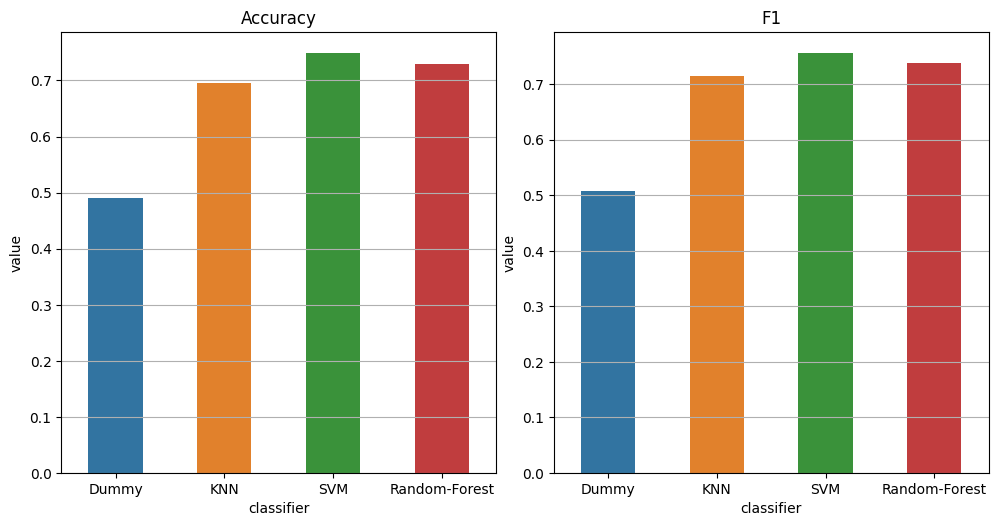

In [56]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()

axs[0].grid(True)
axs[1].grid(True)

axs[0].set_title('Accuracy')
axs[1].set_title('F1')

sns.barplot( data = res_df[ res_df['Metric'] == 'Accuracy' ] , x = 'classifier' , y = 'value' , hue = 'classifier' , ax = axs[0] , width=0.5 )
sns.barplot( data = res_df[ res_df['Metric'] == 'F1' ] , x = 'classifier' , y = 'value' , hue = 'classifier' , ax = axs[1] , width=0.5 )

Here in these charts, we did not include the _Percision_ and _Recall_ but instead we added __F1__ metric which is the _Harmonic Mean_ of percision and recall. 

As it is vivid in the graphs, the __SVM__ classifier beats others both in Accuracy and F1 score but it is nearly followed with an _Optimized_ Random Forst Classifier.

### Sensetivity Analysis
For the sensitivity testing of the models, a few options are available. First, we can chose to peroform either __Local Sensitivity Analysis__ or __Global Sensitivity Analysis__. To keep things simple, a local sensitivity analysis method called OAT (one at a time) will be performed on the KNN model (since it can give us meaningfull output for the OAT analysis) however it is worth mentioning that other options like __Variance-Based methods__, __Moris Method__ and __SHAP__ are also feasible. But, their practicality in our cases can be further disccused (since our models are classification models and Sensitivity analysis is mostly performed on regression models).

#### OAT
One-at-a-Time (OAT) Sensitivity Analysis is a method used to assess the influence of individual input variables on the output of a model. In this method, we vary one input variable at a time while keeping the others constant, and observe the effect on the model's output. This approach is straightforward and easy to implement, making it a popular choice for initial sensitivity analysis.

In [57]:
results_svm = np.zeros((330,))

for case, label in zip(X_test, y_test_sl):
    pred_ = svc.predict([case])
    
    case_X_epand = np.tile(case, 330).reshape(330 , case.shape[0])
    oat_input_vector = np.identity(330)
    
    oat_input_vector = np.logical_or(oat_input_vector , case_X_epand).astype(np.uint8)
    pred_oat = svc.predict(oat_input_vector)

    miss_pred = (pred_oat != pred_).astype(np.uint8)
    results_svm += miss_pred

In [58]:
results_rfc = np.zeros((330,))

for case, label in zip(X_test, y_test_sl):
    pred_ = rfc.predict([case])
    
    case_X_epand = np.tile(case, 330).reshape(330 , case.shape[0])
    oat_input_vector = np.identity(330)
    
    oat_input_vector = np.logical_or(oat_input_vector , case_X_epand).astype(np.uint8)
    pred_oat = rfc.predict(oat_input_vector)

    miss_pred = (pred_oat != pred_).astype(np.uint8)
    results_rfc += miss_pred

In [59]:
results_knn = np.zeros((330,))

for case, label in zip(X_test, y_test_sl):
    pred_ = knn_cls.predict([case])
    
    case_X_epand = np.tile(case, 330).reshape(330 , case.shape[0])
    oat_input_vector = np.identity(330)
    
    oat_input_vector = np.logical_or(oat_input_vector , case_X_epand).astype(np.uint8)
    pred_oat = knn_cls.predict(oat_input_vector)

    miss_pred = (pred_oat != pred_).astype(np.uint8)
    results_knn += miss_pred

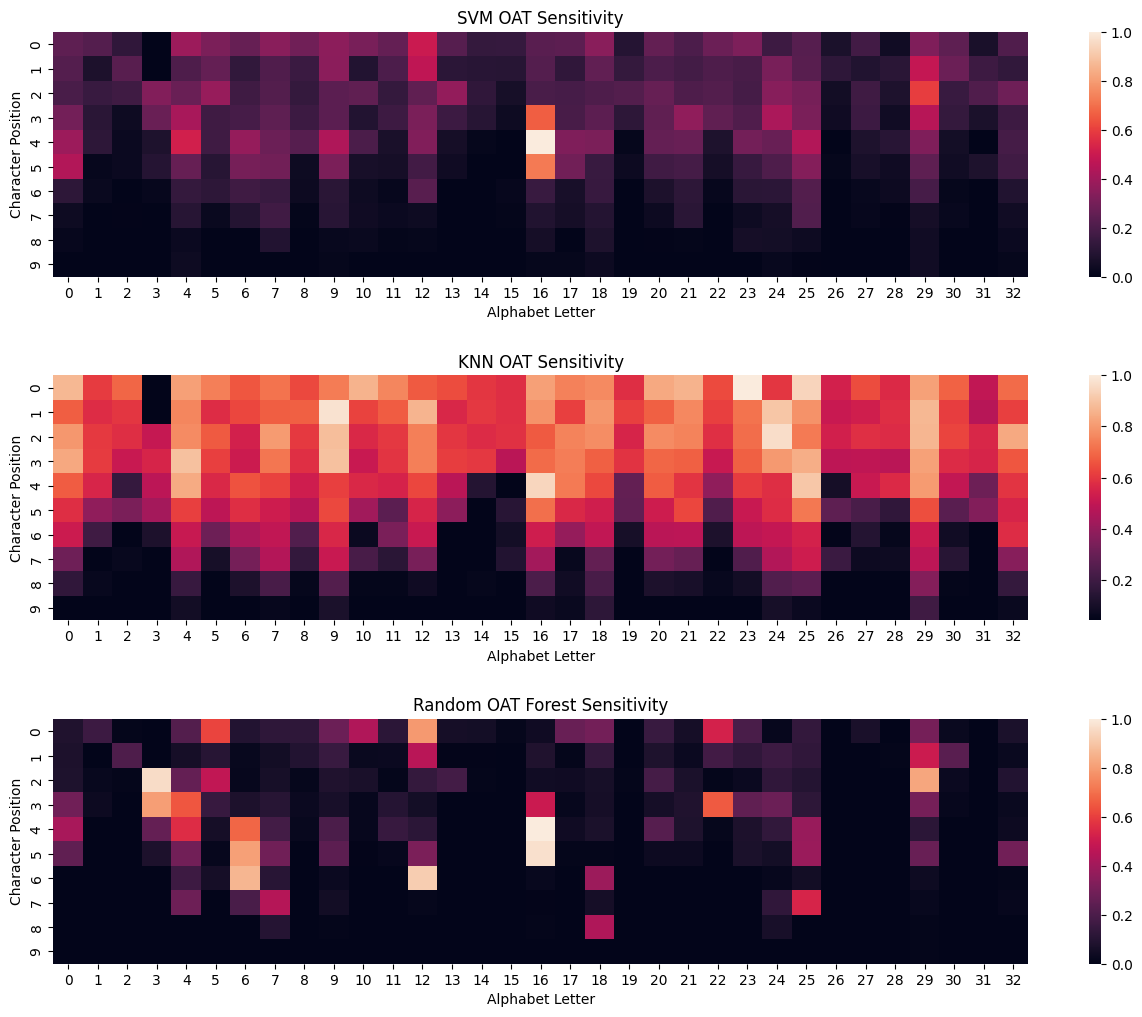

In [62]:
results_svm /= results_svm.max()
results_knn /= results_knn.max()
results_rfc /= results_rfc.max()

fig, ax = plt.subplots(3,1)
fig.set_figwidth(14)
fig.set_figheight(11)
fig.tight_layout(pad = 5)


sns.heatmap(results_svm.reshape(10,33), ax = ax[0])
ax[0].set_title('SVM OAT Sensitivity')

sns.heatmap(results_knn.reshape(10,33), ax = ax[1])
ax[1].set_title('KNN OAT Sensitivity')

sns.heatmap(results_rfc.reshape(10,33), ax = ax[2])
ax[2].set_title('Random OAT Forest Sensitivity')

for ax_ in ax:
    ax_.set_xlabel('Alphabet Letter')
    ax_.set_ylabel('Character Position')


As we can clearly see in our sensitivity heat maps, KNN seemes more prone to noisy data meaning that a typo in the names will most likely reduce the accuracy of KNN significantly. On the other hand, Random forests are generaly less affected by noise. However, it is clear that some character in certain positions, for example letter 25 in the 4th and 5th positions ( letter 'ه' probably beacuse of names such as 'سمانه' and 'عرفانه' ) is very tricky because it will always cause the model to missclassify. (Note that the character orders __must__ be viewd using the `char_table_lookup` variable and not in ordinal, alphabetical order).

The most interesting results however is the SVM sensitivity heat map. It appears that the SVM is also sensitive to letter 25 in the 4th and 5th positions but, it also apears that changes to any letters in last 3 positions (positions 10, 9, 8) is very unlikly to change the outcome of the model. In another word, all of the models (and especially SVM) will care less about the last letters of a _long_ name. 

## Artificial Neural Networks
Artificial Neural Networks (ANNs) are computational models inspired by the human brain's structure and function. They consist of interconnected layers of nodes (neurons) that work together to process information. ANNs are widely used in machine learning for tasks like image recognition, natural language processing, and more.

In comparison to traditional machine learning (statistical learning), they are more powerfull tools in learning complex patterns between different features (non-linear patterns) however, they require more data and are prone to overfiting.

Some Advantages of Neural Networks:
- Handle Non-linear Relationships
- Feature Learnin (Little feature engineering required)

Some Disadvantages of neural networks:
- Requires Large Amounts of Data
- Overfitting
- Hyperparameter Tuning

Here, we encoporate two different ANN types; Dense Networks which are among the most simplest of neural networks and Recursive Networks which are the cutting edge technology in the field of NLP. 
> Unfortunatly, because of limited time, we wont be able to tune the hyper parameters of the networks so much. But, just like the case with the other methods, aproaches such as Gridseatch Cross validationa and Random Search Crossvalidation can be use to tune ANN hyper parameters as well.  
> It is worth mentioning that the parameters were tuned to some extent; For example the learning rate was chosen such that overfriting dosen't take over the network so much. 

### Dense Network
Fully connected networks, composed entirely of Dense layers, are a fundamental type of neural network where each neuron in a layer is connected to every neuron in the preceding layer. These networks are simple yet powerful, capable of learning complex patterns and functioning as universal approximators, meaning they can model any continuous function given enough neurons. However, they tend to have a large number of parameters, making them prone to overfitting (as we'll see shortly), especially on small datasets.

In [99]:
X_train, X_test, y_train_dl, y_test_dl = train_test_split(X_ , y_dl , test_size = 0.25)

In [100]:
model_dense = keras.models.Sequential()
model_dense.add(keras.layers.Input(shape = (330,)))
model_dense.add(keras.layers.Dense(1000, activation = 'relu'))
model_dense.add(keras.layers.Dense(1000, activation = 'relu' , kernel_regularizer = keras.regularizers.l2(1e-2)))
model_dense.add(keras.layers.Dropout(0.5))
model_dense.add(keras.layers.Dense(500, activation = 'elu' , kernel_regularizer = keras.regularizers.l2(1e-2)))
model_dense.add(keras.layers.Dense(2, activation = 'softmax', kernel_regularizer = keras.regularizers.l2(1e-4)))

In [101]:
model_dense.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=8e-5),
    metrics=['accuracy']
)
model_dense.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 1000)           │       331,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │         1,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,833,502 (6.99 MB)

 Trainable params: 1,833,502 (6.99 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
history_dense = model_dense.fit( x= X_train, y= y_train_dl, batch_size=64 , epochs=30, validation_split=0.25)

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5206 - loss: 16.5778 - val_accuracy: 0.6364 - val_loss: 14.2942
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6115 - loss: 13.6191 - val_accuracy: 0.6500 - val_loss: 11.7236
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6526 - loss: 11.1621 - val_accuracy: 0.6591 - val_loss: 9.5993
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6887 - loss: 9.1350 - val_accuracy: 0.6682 - val_loss: 7.8478
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7015 - loss: 7.4595 - val_accuracy: 0.6791 - val_loss: 6.4114
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7146 - loss: 6.0845 - val_accuracy: 0.6899 - val_loss: 5.2472
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7414 - loss: 4.9700 - val_accuracy: 0.6872 - val_loss: 4.3035
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7572 - loss: 4.0568 - val_accuracy: 0.704

In [103]:
pred = model_dense.predict(X_test)
pred = np.argmax(pred , axis = 1)
print(classification_report(np.argmax(y_test_dl , axis = 1) , pred))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       707
           1       0.76      0.74      0.75       764

    accuracy                           0.75      1471
   macro avg       0.75      0.75      0.75      1471
weighted avg       0.75      0.75      0.75      1471



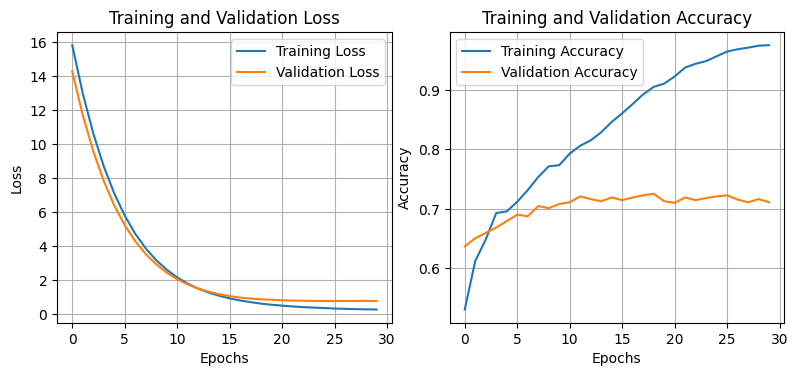

In [104]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(8)
fig.set_figheight(3.5)
fig.tight_layout()

ax[0].plot(history_dense.history['loss'], label='Training Loss')
ax[0].plot(history_dense.history['val_loss'], label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(history_dense.history['accuracy'], label='Training Accuracy')
ax[1].plot(history_dense.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].grid(True)
ax[1].legend()

As it is clear, our model definatly overfited (probably because of the large number of parameters) but it didnt cause the model to decrease the Validation accuracy which is good. However, the performance is very similar to the traditional techniques (close to KNN) as it is vivid in the classification summary.

However, Dense ANN which uses softmax as output is a probablistic model which means that we can plot the __Percision Recall__ Curve to chose a good tradeoff between the two.

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best Threshold:  0.52187335


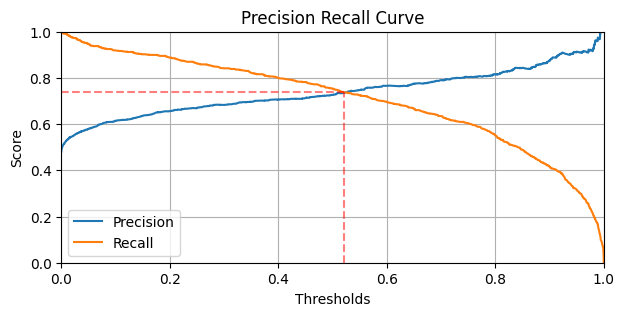

In [105]:
precision, recall, thresholds = precision_recall_curve( y_test_dl[:,0] , model_dense.predict(X_test)[:,0] )
plt.figure(figsize=(7, 3))
plt.plot( thresholds , precision[:-1] , label = 'Precision' )
plt.plot( thresholds , recall[:-1] , label = 'Recall' )

best_tradoff = np.argmin(np.abs(precision - recall))
plt.plot( [thresholds[best_tradoff] , thresholds[best_tradoff]] , [0, precision[best_tradoff]] , c='red' , linestyle='dashed' , alpha = 0.5)
plt.plot( [0 , thresholds[best_tradoff]] , [precision[best_tradoff], precision[best_tradoff]] , c='red', linestyle='dashed'  , alpha = 0.5)
plt.grid(True)
plt.legend()
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.ylim([0,1])
plt.xlim([0,1])
plt.title('Precision Recall Curve')

print('Best Threshold: ' , thresholds[best_tradoff])

In [106]:
pred = model_dense.predict(X_test)
pred = (pred[:,0] > thresholds[best_tradoff]).astype(np.uint8)
print(classification_report(y_test_dl[:,0] , pred))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       764
           1       0.74      0.74      0.74       707

    accuracy                           0.75      1471
   macro avg       0.75      0.75      0.75      1471
weighted avg       0.75      0.75      0.75      1471



So, if we chose our thersholds as it was given above, we will create a good ballance between percision and recall.
#### Some Random Tests

In [108]:
names_ = ['میترا' , 'اسد' , 'دلارام' , 'زیبا' , 'اشکان']
for name in names_:
    word_vec = encoder(name).reshape(-1 , 330, 1)
    pred_ = model_dense.predict([word_vec])

    if pred_[0][0] > thresholds[best_tradoff]:
        print(name, "=>" , 'پسر است', '\tScore:' , pred_[0][0])

    else:
        print(name, "=>" , 'دختر است' , '\tScore:' , pred_[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
میترا => دختر است 	Score: 0.034042817
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
اسد => پسر است 	Score: 0.95439184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
دلارام => دختر است 	Score: 0.21576478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
زیبا => دختر است 	Score: 0.14846905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
اشکان => پسر است 	Score: 0.91729313


### Recursive Neural Nets
> Note that the model structure was borrowed from [Maël Fabien](https://maelfabien.github.io/machinelearning/NLP_7/#building-the-model) article on Gender Classification of French names.

Recurrent Neural Networks (RNNs) with Long Short-Term Memory (LSTM) units are crucial in Natural Language Processing (NLP). LSTMs improve RNNs by managing long-term dependencies, enabling the model to retain important information over longer sequences. This makes them highly effective for tasks like language modeling, text generation, and sentiment analysis, where context over extended sequences is vital.


Despite their strengths, RNNs with LSTM units have some downsides. They can be computationally expensive and slow to train, especially on large datasets, due to their complex architecture. LSTMs also struggle with capturing very long-term dependencies in extremely lengthy sequences. Additionally, they require a large amount of memory and can be difficult to parallelize, which limits their efficiency in certain applications. Newer models like Transformers often outperform LSTMs in many NLP tasks by handling long-range dependencies more effectively and scaling better with data but their implementation is beyond the scope of this project.

In [109]:
X_ = X_.reshape((X_.shape[0], 10 , 33))

In [110]:
X_train, X_test, y_train_dl, y_test_dl = train_test_split(X_ , y_dl , test_size = 0.2)

In [111]:
model_rnn = keras.models.Sequential()
model_rnn.add(keras.layers.Input(shape = (X_train.shape[1],X_train.shape[2],)))
model_rnn.add(keras.layers.Bidirectional(keras.layers.LSTM(500, return_sequences=True), backward_layer=keras.layers.LSTM(500, return_sequences=True, go_backwards=True)))
model_rnn.add(keras.layers.Dropout(0.2))
model_rnn.add(keras.layers.Bidirectional(keras.layers.LSTM(500)))
model_rnn.add(keras.layers.Dropout(0.2))
model_rnn.add(keras.layers.Dense(100, activity_regularizer=keras.regularizers.l2(0.001)))
model_rnn.add(keras.layers.Dense(2,))
model_rnn.add(keras.layers.Activation('softmax'))
model_rnn.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 10, 1000)       │     2,136,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 1000)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 1000)           │     6,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │           202 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,240,302 (31.43 MB)

 Trainable params: 8,240,302 (31.43 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
lr_schedule = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 0.005,
    decay_steps = 100,
    end_learning_rate=0.0001,
    power=6,
    cycle=False,
    name="PolynomialDecay",
)

model_rnn.compile(
    loss = keras.losses.CategoricalFocalCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

In [113]:
history_rnn_1 = model_rnn.fit( x= X_train, y= y_train_dl, batch_size=256 , epochs=40, validation_split=0.25)
history_rnn_2 = model_rnn.fit( x= X_train, y= y_train_dl, batch_size=128 , epochs=30, validation_split=0.25)
history_rnn_3 = model_rnn.fit( x= X_train, y= y_train_dl, batch_size=64 , epochs=20, validation_split=0.25)
history_rnn_4 = model_rnn.fit( x= X_train, y= y_train_dl, batch_size=32 , epochs=10, validation_split=0.25)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5120 - loss: 0.0611 - val_accuracy: 0.5692 - val_loss: 0.0451
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6294 - loss: 0.0444 - val_accuracy: 0.6559 - val_loss: 0.0425
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6814 - loss: 0.0424 - val_accuracy: 0.6729 - val_loss: 0.0419
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6882 - loss: 0.0419 - val_accuracy: 0.6780 - val_loss: 0.0418
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6863 - loss: 0.0418 - val_accuracy: 0.6763 - val_loss: 0.0417
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6904 - loss: 0.0418 - val_accuracy: 0.6890 - val_loss: 0.0416
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6936 - loss: 0.0418 - val_accuracy: 0.6797 - val_loss: 0.0416
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7018 - loss: 0.0415 - val_accuracy: 0.6907 - val_loss:

This training approach while uncoventional, progressively reduces the batch size while simultaneously decreasing the number of epochs. The idea is to start with a __larger batch__ size to allow for faster and more stable convergence in the earlier stages, where the model can make broad adjustments. As training progresses, reducing the batch size allows for finer adjustments to the model's weights, potentially leading to better generalization. This strategy can help avoid getting stuck in local minima and improve the model's performance by making more precise updates in the later stages of training.

In [115]:
pred = model_rnn.predict(X_test)
pred = np.argmax(pred , axis = 1)
print(classification_report(np.argmax(y_test_dl , axis = 1) , pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step
              precision    recall  f1-score   support

           0       0.69      0.70      0.69       558
           1       0.72      0.71      0.72       619

    accuracy                           0.71      1177
   macro avg       0.71      0.71      0.71      1177
weighted avg       0.71      0.71      0.71      1177



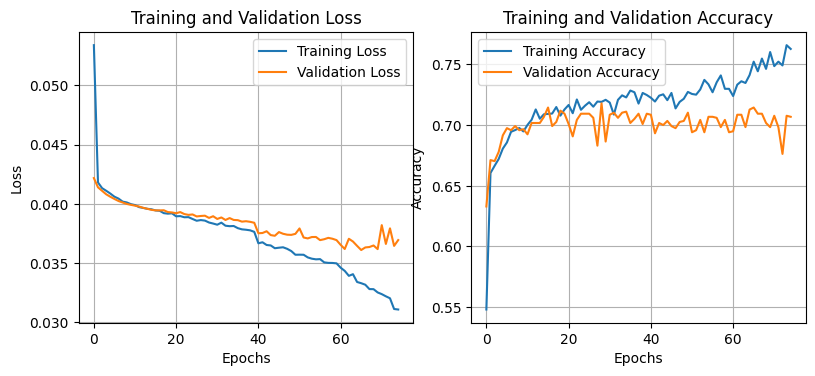

In [117]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(8)
fig.set_figheight(3.5)
fig.tight_layout()

history_train_loss = history1.history['loss'] + history2.history['loss'] + history3.history['loss'] + history4.history['loss']
history_val_loss = history1.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'] + history4.history['val_loss']
history_train_acc = history1.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy'] + history4.history['accuracy']
history_val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy'] + history4.history['val_accuracy']

ax[0].plot(history_train_loss, label='Training Loss')
ax[0].plot(history_val_loss, label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(history_train_acc, label='Training Accuracy')
ax[1].plot(history_val_acc, label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].grid(True)
ax[1].legend()

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step
Best Threshold:  0.5044263


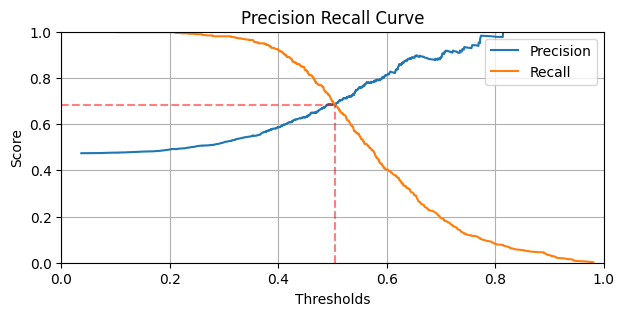

In [118]:
precision, recall, thresholds = precision_recall_curve( y_test_dl[:,0] , model_rnn.predict(X_test)[:,0] )
plt.figure(figsize=(7, 3))
plt.plot( thresholds , precision[:-1] , label = 'Precision' )
plt.plot( thresholds , recall[:-1] , label = 'Recall' )

best_tradoff = np.argmin(np.abs(precision - recall))
plt.plot( [thresholds[best_tradoff] , thresholds[best_tradoff]] , [0, precision[best_tradoff]] , c='red' , linestyle='dashed' , alpha = 0.5)
plt.plot( [0 , thresholds[best_tradoff]] , [precision[best_tradoff], precision[best_tradoff]] , c='red', linestyle='dashed'  , alpha = 0.5)
plt.grid(True)
plt.legend()
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.ylim([0,1])
plt.xlim([0,1])
plt.title('Precision Recall Curve')

print('Best Threshold: ' , thresholds[best_tradoff])

In [120]:
pred = model_rnn.predict(X_test)
pred = (pred[:,0] > thresholds[best_tradoff]).astype(np.uint8)
print(classification_report(y_test_dl[:,0] , pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       619
           1       0.69      0.68      0.69       558

    accuracy                           0.70      1177
   macro avg       0.70      0.70      0.70      1177
weighted avg       0.70      0.70      0.70      1177



As we can see clearly, using a gradually reduce learning rate (using schedules) had helped in reducing the overfitting in our network. However, it looks like that the Dense model actually did a better job at learning the patterns in our data. This can be due to many factors; For example, it could indicate that our data is __Non-Sequential__. Also, the lower performance could mean that we have a case of __Vanishing Gradient__. One other reaseon, might be the size of our dataset, since a dataset of only about $3500$ entries might not be big enought to train an RNN.

# Comparing the Results

In [145]:
## Create random tests from dataset
random_indicies = np.arange(0, 1000)
random_indicies = np.random.shuffle(random_indicies)

X_test = np.stack(df['encode'].to_numpy() , axis = 0)[random_indicies]
y_test = df['gender_bin'].to_numpy()[random_indicies].reshape(-1)

X_test = X_test.reshape( X_test.shape[1] , 10, 33)
rnn_predict = model_rnn.predict(X_test)
X_test = X_test.reshape( X_test.shape[0] , -1)
dummy_predict = dummy.predict(X_test)
dense_predict = model_dense.predict(X_test)
svm_pred = svc.predict(X_test)

acc_dummy = accuracy_score(y_test , dummy_predict )
perc_dummy = precision_score(y_test , dummy_predict )
rec_dummy = recall_score(y_test , dummy_predict )
f1_dummy = f1_score(y_test , dummy_predict )
#------------------------------------------------------------------------------------------------
acc_rnn = accuracy_score(y_test , rnn_predict[:,0] < 0.5 )
perc_rnn = precision_score(y_test , rnn_predict[:,0] < 0.5 )
rec_rnn = recall_score(y_test , rnn_predict[:,0] < 0.5 )
f1_rnn = f1_score(y_test , rnn_predict[:,0] < 0.5 )
#------------------------------------------------------------------------------------------------
acc_dense = accuracy_score(y_test , dense_predict[:,0] < 0.5 )
perc_dense = precision_score(y_test , dense_predict[:,0] < 0.5 )
rec_dense = recall_score(y_test , dense_predict[:,0] < 0.5 )
f1_dense = f1_score(y_test , dense_predict[:,0] < 0.5 )
#------------------------------------------------------------------------------------------------
acc_svc = accuracy_score(y_test , svm_pred )
perc_svc = precision_score(y_test , svm_pred )
rec_svc = recall_score(y_test , svm_pred )
f1_svc = f1_score(y_test , svm_pred )


comp_results = [
         { 'classifier': "Dummy", 'Accuracy' : acc_dummy, 'Percision' : perc_dummy , 'Recall' : rec_dummy, 'F1': f1_dummy },
         { 'classifier': "Dense", 'Accuracy' : acc_dense, 'Percision' : perc_dense , 'Recall' : rec_dense, 'F1': f1_dense },
         { 'classifier': "RNN",  'Accuracy' : acc_rnn, 'Percision' : perc_rnn , 'Recall' : rec_rnn, 'F1': f1_rnn },
         { 'classifier': "SVM",  'Accuracy' : acc_svc, 'Percision' : perc_svc , 'Recall' : rec_svc, 'F1': f1_svc },
]

res_df = pd.DataFrame(comp_results)
res_df.head()

res_df.set_index('classifier', inplace=True)
res_df = res_df.stack().to_frame('value').reset_index()
res_df.rename(columns={'level_1':'Metric'},inplace=True)

184/184 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


<Axes: title={'center': 'F1'}, xlabel='classifier', ylabel='value'>

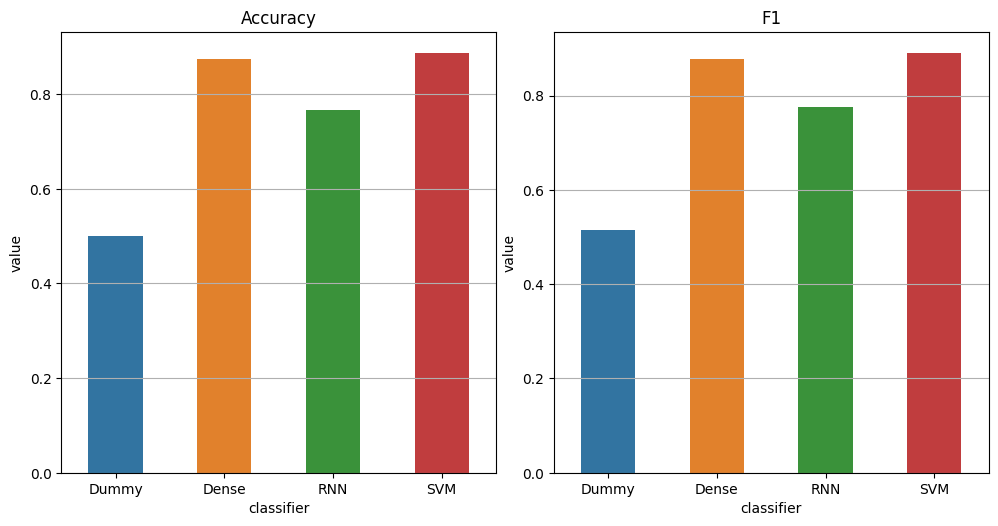

In [146]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()

axs[0].grid(True)
axs[1].grid(True)

axs[0].set_title('Accuracy')
axs[1].set_title('F1')

sns.barplot( data = res_df[ res_df['Metric'] == 'Accuracy' ] , x = 'classifier' , y = 'value' , hue = 'classifier' , ax = axs[0] , width=0.5 )
sns.barplot( data = res_df[ res_df['Metric'] == 'F1' ] , x = 'classifier' , y = 'value' , hue = 'classifier' , ax = axs[1] , width=0.5 )

As evident from the graphs, the __RNN__ was outperformed by both the __SVM__ and __Dense__ networks, which performed almost equally well. This unusual occurrence calls for further investigation; however, this is beyond the scope of this notebook as it would require a more in-depth analysis of the network structure, learning methods, and other factors.

Another point worth addressing is that nearly all models achieved around $75\%$ test accuracy, suggesting that the dataset may not be classifiable beyond this point—potentially an inherent characteristic of the Farsi language. Gathering more data could help clarify this claim.

Despite the similarity in performance between the SVM and Dense networks, with SVM performing slightly better, this marks a clear victory for the SVM. It outperformed all the models, is less sensitive to noise, and is also much simpler compared to the other models.

# Conclusion

In conclusion, the dataset of Farsi names appears to be classifiable using machine learning techniques, achieving an accuracy of around $75\%$. The most effective model for this task is the Support Vector Machine with a polynomial kernel of degree $3$.

Further research could explore additional approaches, such as using **Transforms** for classification, more advanced feature engineering, and increasing the dataset size beyond the current $6,000$ data points. Also, model structures from [[2]](./2102.03692v1.pdf) , [[3]](./2106.10156v2.pdf) , [[4]](./Ritwick_Ghosh__Paper.pdf) could also be implemented to directly compare the results with these papers but it was curently skiped as the number of network structures used in these papers are large (This could also be used to investigate the claim that Farsi names aren't classifiable beyond the $75\%$ accuracy mark).

However, for real-world applications, it could be argued that creating a Look-Up Table for gender classification of names might be more practical and viable. Given that the set of Farsi names is relatively static and unlikely to grow significantly in the coming century, a look-up table could be a more efficient solution.